In [196]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from tqdm import tqdm
from collections import defaultdict
import random
import matplotlib.pyplot as plt


A move is represented as an integer like that

0 | 1 | 2  \
--+---+--  \
3 | 4 | 5  \
--+---+--  \
6 | 7 | 8

I think we should make a Player class similar to OptimalPlayer. Basically we modify the 'act' function for different learning algorithms.
It should look something like that: 

In [165]:
class QPlayer:
    def __init__(self, epsilon=0.2, alpha=0.05, gamma=0.99, player='X'):
        self.epsilon = epsilon
        self.player = player # 'x' or 'O'
        self.alpha = alpha
        self.gamma = gamma
        # 3^9 states 9 length vectors are keys and 9 length list of values represents actions 
        self.Qvalues = defaultdict(lambda: [0 for _ in range(9)]) 
        self.current_action = None
        
    def empty(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(i)
        return avail

    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)
        return avail[random.randint(0, len(avail)-1)]

    def act(self, grid):
        # epsilon greedy policy
        if random.random() < self.epsilon:
            action = self.randomMove(grid)
        else:
            avail = self.empty(grid)
            idx = np.argmax([self.Qvalues[str(grid)][pos] for pos in avail])
            action = avail[idx]
        self.current_action = action    
        return action

    def updateQ(self, grid, end):
        if (end == True):
            reward = 1
            off_policy = 0
        else:
            reward = 0
            off_policy = max([self.Qvalues[str(grid)][pos] for pos in self.empty(grid)])
        q = self.Qvalues[str(grid)][self.current_action] 
        self.Qvalues[str(grid)][self.current_action] = q + self.alpha * (reward + self.gamma * off_policy - q)

            


Helper function to evaluate games:

In [180]:
def simulate(agent1, agent2, N=500):
    env = TictactoeEnv()
    N_win = 0
    N_loose = 0
    history = []
    turns = np.array(['X','O'])
    flip = np.array([1,0])
    for i in tqdm(range(N)):
        # initialize env and players
        env.reset()
        grid, _, __ = env.observe()

        turns = turns[flip]
        agent1.player = turns[0]
        agent2.player = turns[1]

        # simulation
        for j in range(9):
            if env.current_player == agent1.player:
                move = agent1.act(grid)
                grid, end, winner = env.step(move, print_grid=False)
                agent1.updateQ(grid, end)
            else:
                move = agent2.act(grid)
                grid, end, winner = env.step(move, print_grid=False)

            if end:
                # store results
                if winner == agent1.player:
                    N_win += 1
                    history.append(1)
                elif winner == agent2.player:
                    N_loose += 1
                    history.append(-1)
                else:
                    history.append(0)
                break
    return history, (N_win - N_loose) / N
            


100%|██████████| 20000/20000 [03:09<00:00, 105.42it/s]


-0.30585


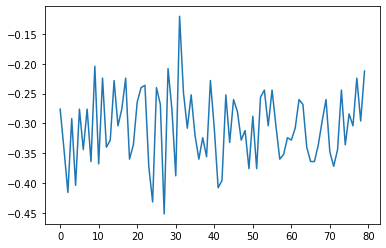

In [205]:
agent1 = QPlayer(epsilon=0.1)
agent2 = OptimalPlayer(epsilon=0.5)
history, metric = simulate(agent1, agent2, N=20000)
results = np.mean(np.array(history).reshape(80,250), axis=1)
print(metric)
plt.plot(results)

100%|██████████| 20000/20000 [02:22<00:00, 140.73it/s]

0.2151


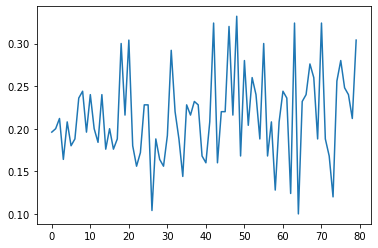

In [206]:
agent1 = QPlayer(epsilon=0.1)
agent2 = OptimalPlayer(epsilon=1)
history, metric = simulate(agent1, agent2, N=20000)
results = np.mean(np.array(history).reshape(80,250), axis=1)
print(metric)
plt.plot(results)